***Anindita Basu***
**TSA Project**

# Import Required Libraries and functions

In [4]:
# Time Series Analysis Spring 2024
# Forecasting Financial instruments price with VECM and ARIMA model
# Author: Anindita Basu, Vikram Bahadur

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd # for data processing
import numpy as np # here mostly for series generation

import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots

import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

import yfinance as yf # for importing data directly from finance.yahoo.com

import warnings
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from IPython.display import display
# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
def adf_test(series, max_aug=10, version='n'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        #print('aug', i)
        
        for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 500:
                cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 500:
                cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 500:
                cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

        results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    display(results_df)
    return results_df

# data loading

In [6]:


# Set display and plotting options
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

sns.set_context("talk")

# 1. Data importing
# Load the dataset
TS2 = pd.read_csv("TSA_2025_project_data_1.csv")

# Check structure
print(TS2.info())
print(TS2.head())
print(TS2.tail())

# Convert 'date' column to datetime
TS2['date'] = pd.to_datetime(TS2['date'], format='%Y-%m-%d')
TS2.set_index('date', inplace=True)

# Ensure only y1 to y10 columns are selected
price_cols = [f"y{i}" for i in range(1, 11)]
TS2 = TS2[price_cols]

# Create first differences
for col in price_cols:
    TS2[f'd{col}'] = TS2[col].diff()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   y1      600 non-null    float64
 2   y2      600 non-null    float64
 3   y3      600 non-null    float64
 4   y4      600 non-null    float64
 5   y5      600 non-null    float64
 6   y6      600 non-null    float64
 7   y7      600 non-null    float64
 8   y8      600 non-null    float64
 9   y9      600 non-null    float64
 10  y10     600 non-null    float64
dtypes: float64(10), object(1)
memory usage: 51.7+ KB
None
         date       y1       y2       y3       y4       y5       y6       y7  \
0  2023-09-09 109.4100 109.4100 109.4100 124.2400 124.4700 109.4100 119.9400   
1  2023-09-10 109.4100 109.4100 109.4100 124.2100 124.3200 109.4100 101.3900   
2  2023-09-11 109.4200 109.4100 109.4100 124.4100 124.3700 109.4100  97.6400   
3  2023-09-12 108.6800 110.1900 111

In [7]:
# Preview the transformed data
TS2.head()




,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,dy1,dy2,dy3,dy4,dy5,dy6,dy7,dy8,dy9,dy10
date,,,,,,,,,,,,,,,,,,,,
2023-09-09,109.4100,109.4100,109.4100,124.2400,124.4700,109.4100,119.9400,104.6600,107.6200,119.3200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-10,109.4100,109.4100,109.4100,124.2100,124.3200,109.4100,101.3900,104.3400,102.6100,119.3600,0.0000,0.0000,0.0000,-0.0300,-0.1500,0.0000,-18.5500,-0.3200,-5.0100,0.0400
2023-09-11,109.4200,109.4100,109.4100,124.4100,124.3700,109.4100,97.6400,104.2300,99.1600,119.3800,0.0100,0.0000,0.0000,0.2000,0.0500,0.0000,-3.7500,-0.1100,-3.4500,0.0200
2023-09-12,108.6800,110.1900,111.1200,123.9300,124.8200,109.4100,94.3500,107.2300,103.3900,121.0600,-0.7400,0.7800,1.7100,-0.4800,0.4500,0.0000,-3.2900,3.0000,4.2300,1.6800
2023-09-13,106.2100,110.8800,112.9200,122.6800,123.9100,107.8400,96.2200,109.7100,102.4300,122.1700,-2.4700,0.6900,1.8000,-1.2500,-0.9100,-1.5700,1.8700,2.4800,-0.9600,1.1100


# Initial Visualization

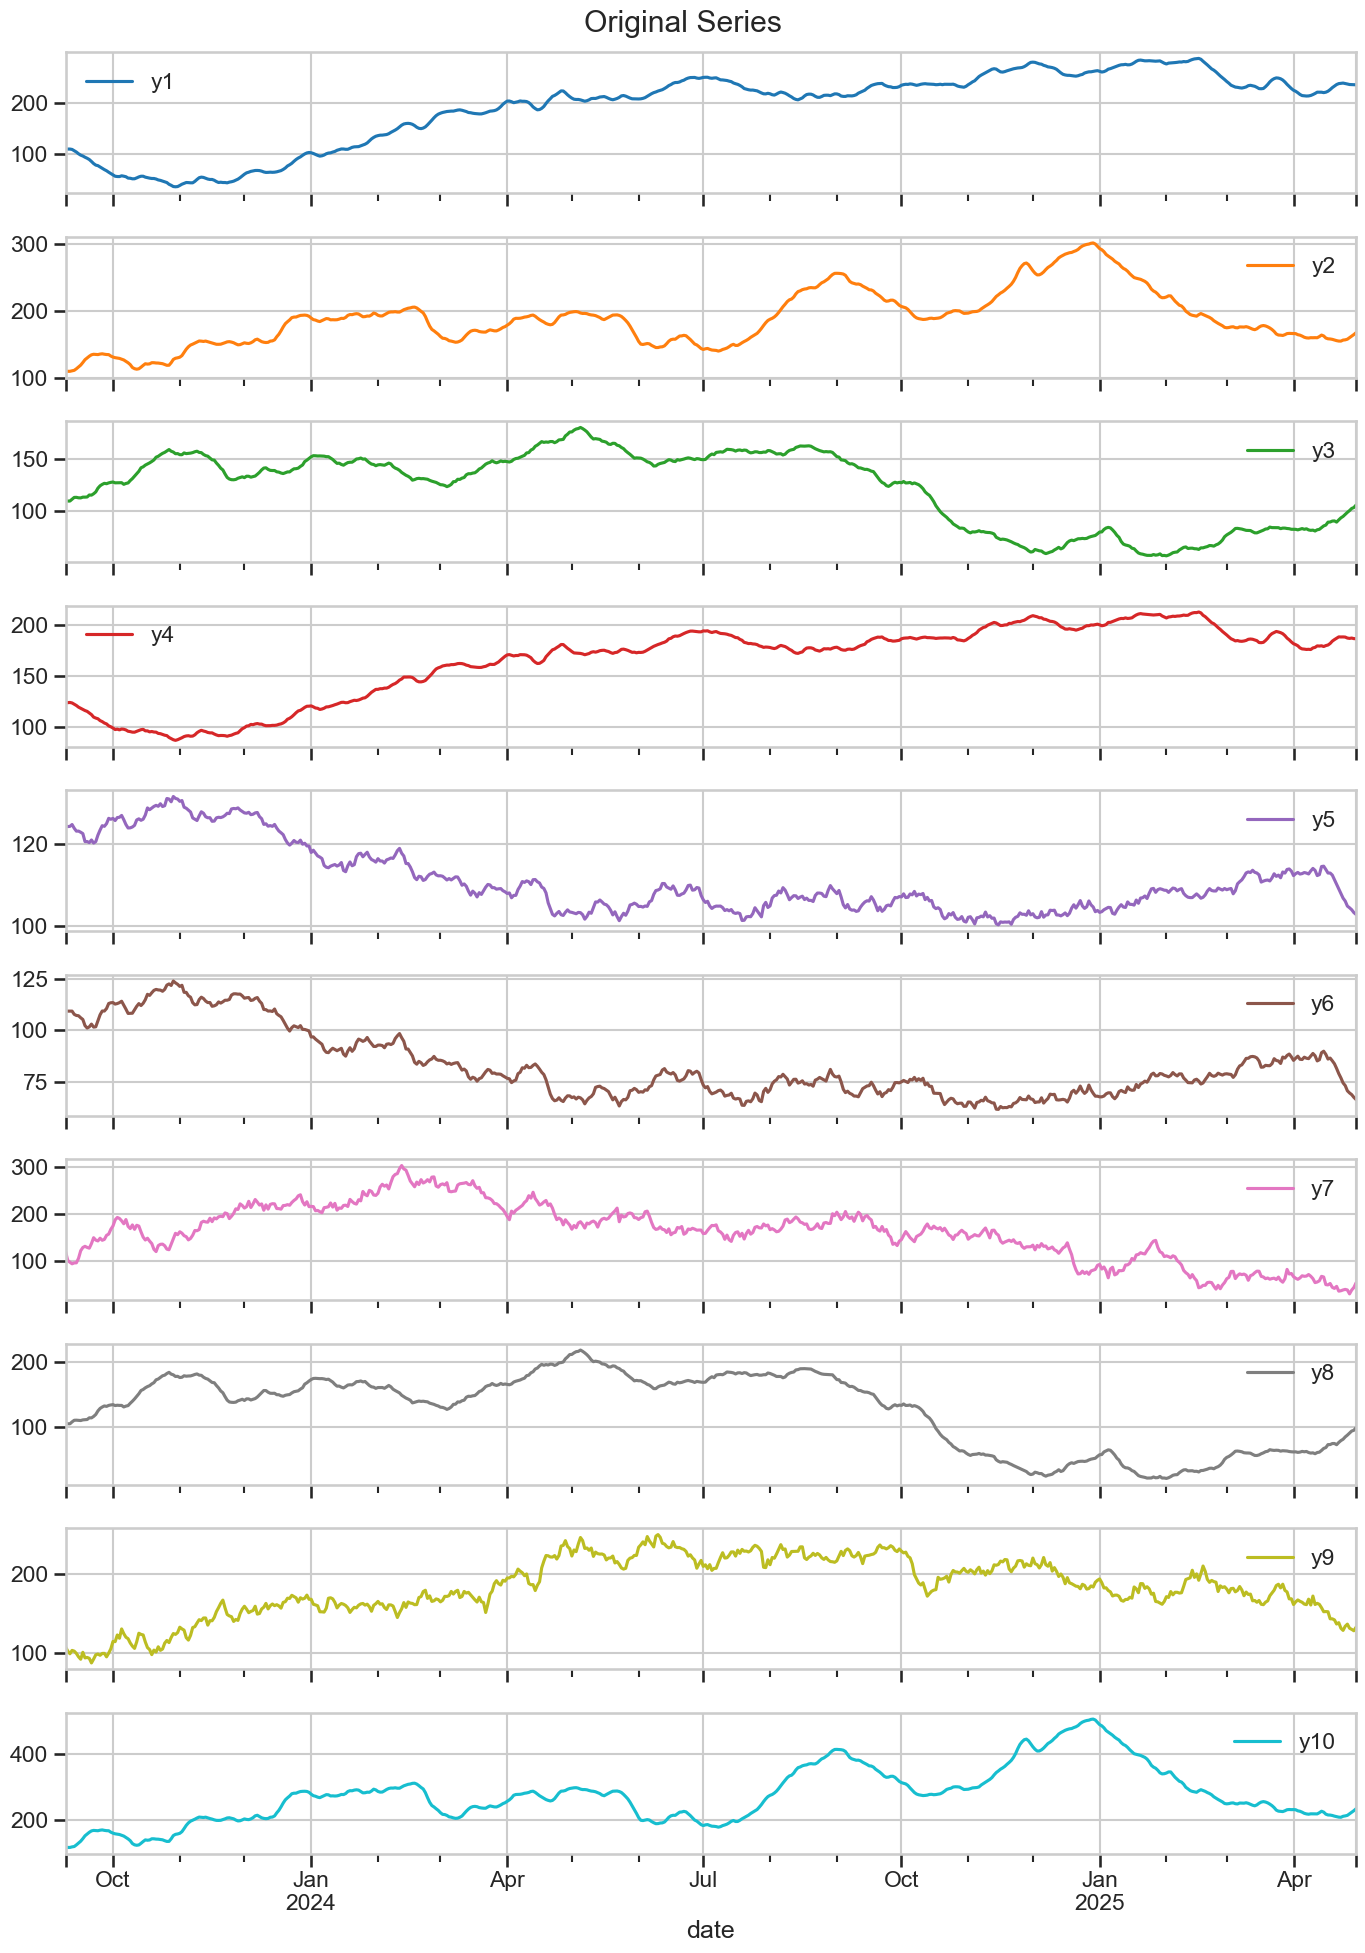

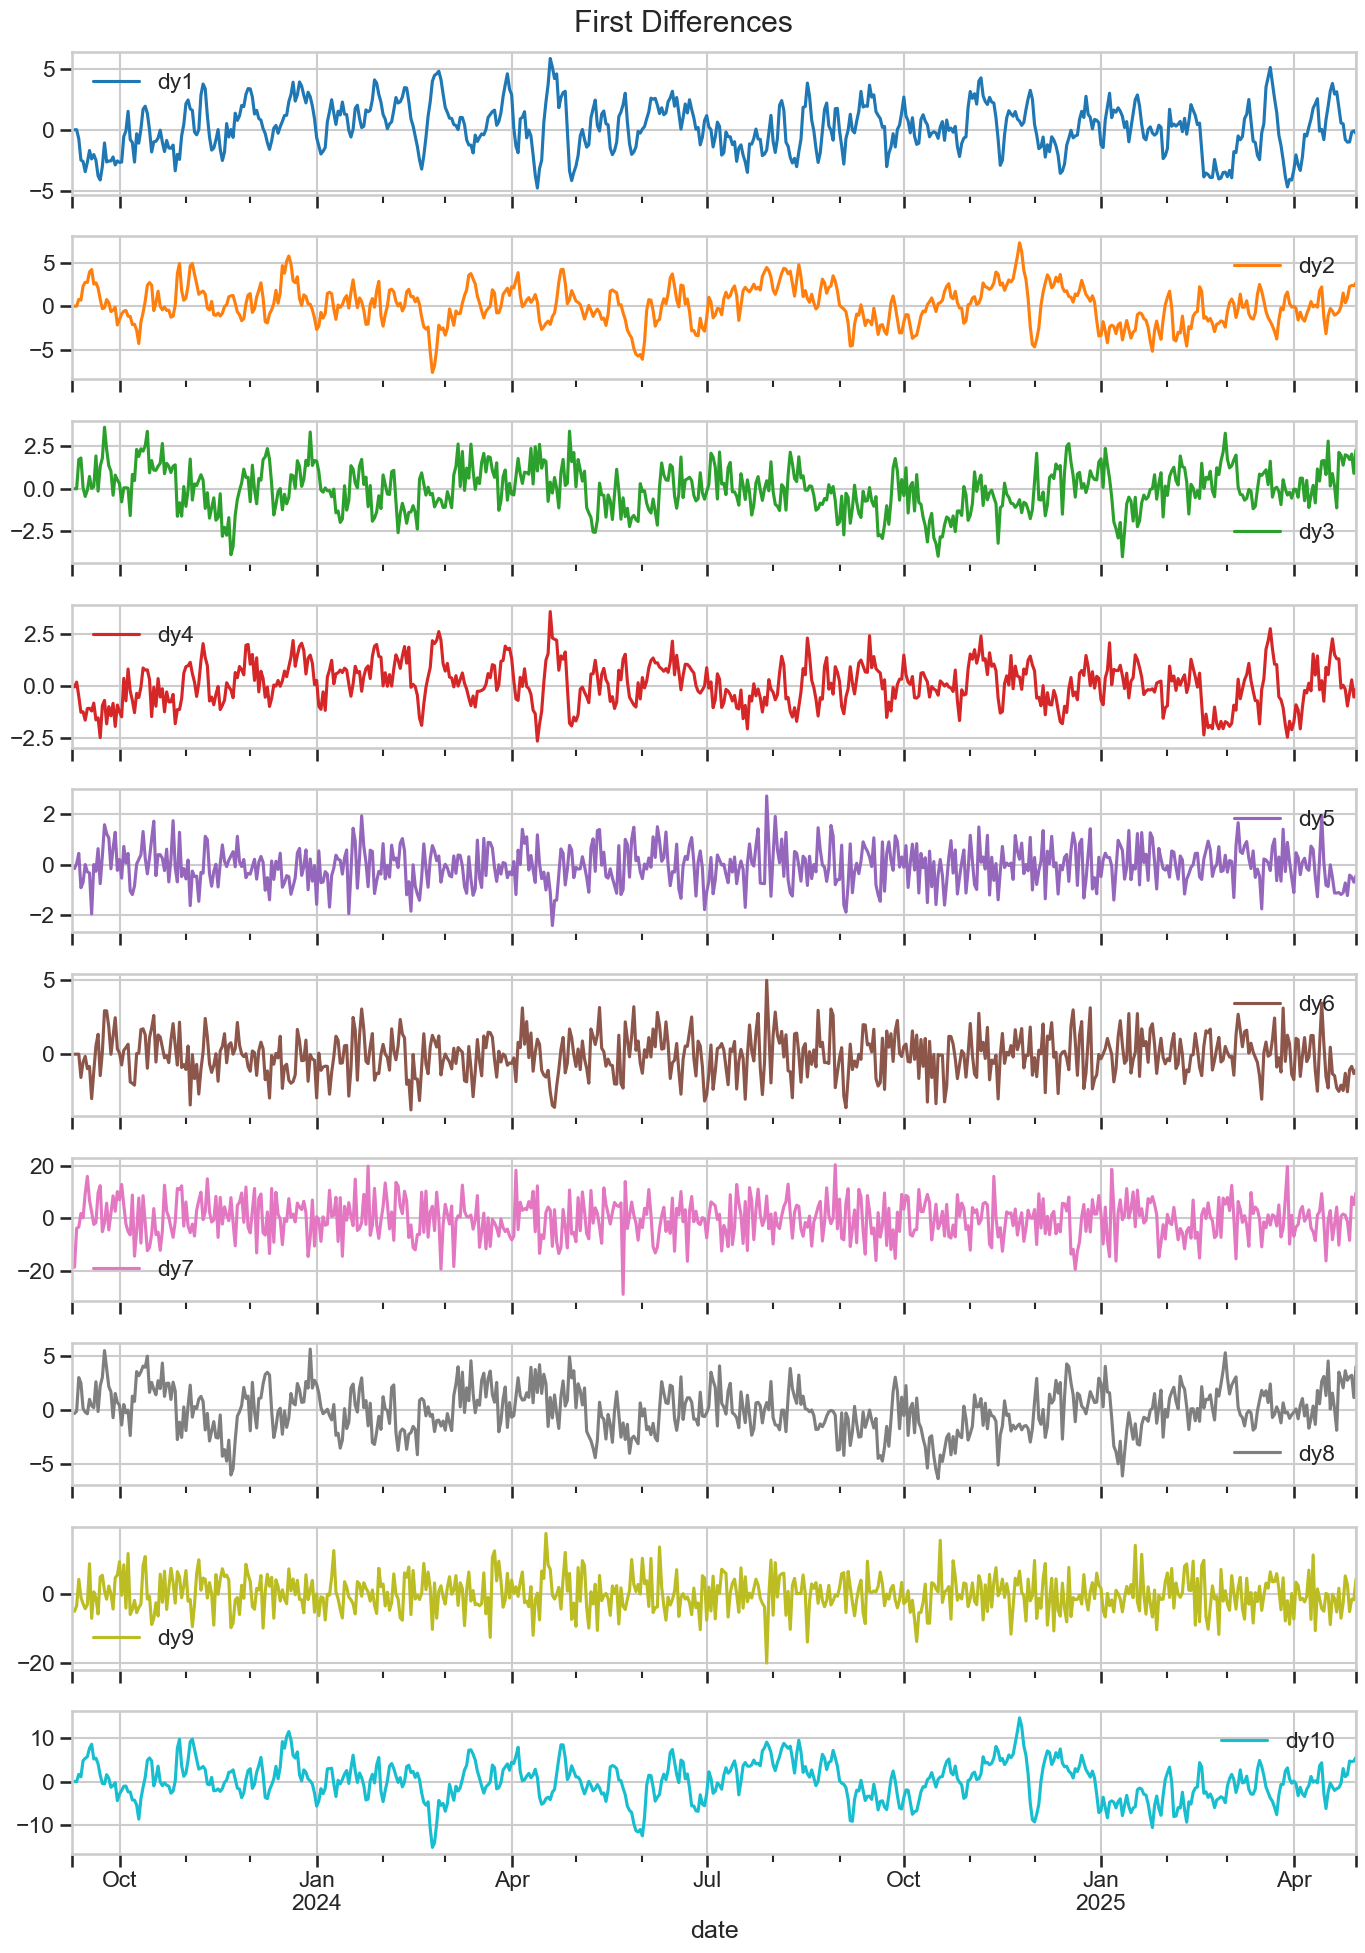

In [8]:
# Plot raw time series data
TS2[price_cols].plot(subplots=True, figsize=(14, 20), title="Original Series")
plt.tight_layout()
plt.show()

# Plot first differences
diff_cols = [f'd{col}' for col in price_cols]
TS2[diff_cols].plot(subplots=True, figsize=(14, 20), title="First Differences")
plt.tight_layout()
plt.show()

# ADF Test for Each Series and their first diff

In [9]:
for i in range(1, 11):
    if i!= 3 and i!= 6:
        y = f'y{i}'
        dy = f'dy{i}'
        print(y)
        t1 = adf_test(TS2[y])




y1


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,2.0808,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,0.2149,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,0.4878,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
3,3,0.6896,-2.5670,-1.9410,-1.6160,0.0001,0.0001,0.0006
4,4,0.5354,-2.5670,-1.9410,-1.6160,0.0574,0.0859,0.0283
5,5,0.5848,-2.5670,-1.9410,-1.6160,0.0095,0.0162,0.0196
6,6,0.7215,-2.5670,-1.9410,-1.6160,0.0261,0.1322,0.1180
7,7,0.6517,-2.5670,-1.9410,-1.6160,0.0990,0.1123,0.0945
8,8,0.7016,-2.5670,-1.9410,-1.6160,0.1066,0.0277,0.0917
9,9,0.6562,-2.5670,-1.9410,-1.6160,0.1249,0.0529,0.0414


y2


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,0.6323,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-0.2178,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-0.0356,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
3,3,-0.1830,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
4,4,-0.0884,-2.5670,-1.9410,-1.6160,0.0000,0.0002,0.0016
5,5,-0.2108,-2.5670,-1.9410,-1.6160,0.0017,0.0136,0.0724
6,6,-0.1384,-2.5670,-1.9410,-1.6160,0.1813,0.2791,0.5101
7,7,-0.1898,-2.5670,-1.9410,-1.6160,0.0816,0.3021,0.5618
8,8,-0.2082,-2.5670,-1.9410,-1.6160,0.3794,0.1981,0.4041
9,9,-0.2630,-2.5670,-1.9410,-1.6160,0.1116,0.3315,0.5005


y4


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,2.2286,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,0.7225,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0002
2,2,0.5528,-2.5670,-1.9410,-1.6160,0.0004,0.0034,0.0088
3,3,0.7673,-2.5670,-1.9410,-1.6160,0.1998,0.3826,0.3553
4,4,0.8407,-2.5670,-1.9410,-1.6160,0.4572,0.5069,0.4494
5,5,0.8130,-2.5670,-1.9410,-1.6160,0.2292,0.5038,0.3251
6,6,0.8876,-2.5670,-1.9410,-1.6160,0.4314,0.5146,0.3404
7,7,0.8742,-2.5670,-1.9410,-1.6160,0.2851,0.2489,0.2834
8,8,0.9327,-2.5670,-1.9410,-1.6160,0.2300,0.1458,0.1144
9,9,0.8983,-2.5670,-1.9410,-1.6160,0.1542,0.0512,0.0761


y5


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-1.2688,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-1.1281,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-1.1608,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
3,3,-1.1653,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
4,4,-0.9043,-2.5670,-1.9410,-1.6160,0.0002,0.0041,0.0066
5,5,-0.9371,-2.5670,-1.9410,-1.6160,0.0162,0.0887,0.0589
6,6,-0.9640,-2.5670,-1.9410,-1.6160,0.0050,0.0774,0.0239
7,7,-0.9906,-2.5670,-1.9410,-1.6160,0.0078,0.0095,0.0075
8,8,-1.0729,-2.5670,-1.9410,-1.6160,0.2791,0.1267,0.2653
9,9,-0.9391,-2.5670,-1.9410,-1.6160,0.6612,0.0707,0.1505


y7


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-0.6996,-2.5670,-1.9410,-1.6160,0.4613,0.0233,0.0272
1,1,-0.6231,-2.5670,-1.9410,-1.6160,0.4872,0.0151,0.0203
2,2,-0.6159,-2.5670,-1.9410,-1.6160,0.5636,0.0156,0.0222
3,3,-0.6073,-2.5670,-1.9410,-1.6160,0.5500,0.0097,0.0147
4,4,-0.5976,-2.5670,-1.9410,-1.6160,0.0395,0.0031,0.0042
5,5,-0.5801,-2.5670,-1.9410,-1.6160,0.0006,0.0055,0.0096
6,6,-0.6305,-2.5670,-1.9410,-1.6160,0.0015,0.0102,0.0263
7,7,-0.7077,-2.5670,-1.9410,-1.6160,0.1953,0.1006,0.0804
8,8,-0.7200,-2.5670,-1.9410,-1.6160,0.1404,0.3318,0.1238
9,9,-0.7392,-2.5670,-1.9410,-1.6160,0.0314,0.2272,0.1502


y8


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-0.2780,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-0.3740,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-0.4542,-2.5670,-1.9410,-1.6160,0.0044,0.0415,0.1367
3,3,-0.5453,-2.5670,-1.9410,-1.6160,0.1630,0.2057,0.4031
4,4,-0.5970,-2.5670,-1.9410,-1.6160,0.0826,0.2996,0.4864
5,5,-0.5667,-2.5670,-1.9410,-1.6160,0.2254,0.4007,0.6048
6,6,-0.5139,-2.5670,-1.9410,-1.6160,0.6193,0.9210,0.8221
7,7,-0.5159,-2.5670,-1.9410,-1.6160,0.8382,0.9875,0.9180
8,8,-0.5415,-2.5670,-1.9410,-1.6160,0.7235,0.5831,0.3712
9,9,-0.5534,-2.5670,-1.9410,-1.6160,0.2550,0.5280,0.4123


y9


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-0.2078,-2.5670,-1.9410,-1.6160,0.2016,0.4478,0.4301
1,1,-0.1688,-2.5670,-1.9410,-1.6160,0.1621,0.4141,0.3835
2,2,-0.1694,-2.5670,-1.9410,-1.6160,0.2291,0.4886,0.4571
3,3,-0.1779,-2.5670,-1.9410,-1.6160,0.2210,0.4377,0.4154
4,4,-0.1511,-2.5670,-1.9410,-1.6160,0.3874,0.3001,0.2934
5,5,-0.1254,-2.5670,-1.9410,-1.6160,0.0433,0.1866,0.1919
6,6,-0.0962,-2.5670,-1.9410,-1.6160,0.0625,0.1736,0.1739
7,7,-0.0594,-2.5670,-1.9410,-1.6160,0.1248,0.2593,0.2864
8,8,-0.1108,-2.5670,-1.9410,-1.6160,0.1490,0.4886,0.3636
9,9,-0.0906,-2.5670,-1.9410,-1.6160,0.3596,0.7604,0.5143


y10


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,0.4741,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-0.4151,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-0.2048,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
3,3,-0.3630,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0002
4,4,-0.2600,-2.5670,-1.9410,-1.6160,0.0002,0.0009,0.0027
5,5,-0.3811,-2.5670,-1.9410,-1.6160,0.0078,0.0330,0.1024
6,6,-0.3027,-2.5670,-1.9410,-1.6160,0.2726,0.2560,0.4065
7,7,-0.3481,-2.5670,-1.9410,-1.6160,0.1057,0.2437,0.3875
8,8,-0.3606,-2.5670,-1.9410,-1.6160,0.2924,0.1594,0.2423
9,9,-0.4175,-2.5670,-1.9410,-1.6160,0.1315,0.3202,0.2822


None of the series above is stationary

In [10]:
for i in range(1, 11):
    if i!= 3 and i!= 6:
        y = f'y{i}'
        dy = f'dy{i}'
        print(dy)
        t2 = adf_test(TS2[dy])



dy1


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-7.0586,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-8.7037,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-9.5678,-2.5670,-1.9410,-1.6160,0.0002,0.0003,0.0012
3,3,-7.6225,-2.5670,-1.9410,-1.6160,0.1332,0.1652,0.0599
4,4,-7.5581,-2.5670,-1.9410,-1.6160,0.0230,0.0378,0.0449
5,5,-7.9065,-2.5670,-1.9410,-1.6160,0.0671,0.2771,0.2244
6,6,-7.0844,-2.5670,-1.9410,-1.6160,0.2393,0.2443,0.2047
7,7,-7.1312,-2.5670,-1.9410,-1.6160,0.2460,0.0604,0.1867
8,8,-6.4026,-2.5670,-1.9410,-1.6160,0.3546,0.1429,0.1167
9,9,-6.4673,-2.5670,-1.9410,-1.6160,0.1425,0.3101,0.3013


dy2


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-6.7113,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-8.7416,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-6.5442,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0004
3,3,-7.3582,-2.5670,-1.9410,-1.6160,0.0005,0.0015,0.0086
4,4,-6.2006,-2.5670,-1.9410,-1.6160,0.0127,0.0670,0.2315
5,5,-6.7484,-2.5670,-1.9410,-1.6160,0.7404,0.7056,0.8556
6,6,-6.1646,-2.5670,-1.9410,-1.6160,0.4143,0.7674,0.9076
7,7,-6.1185,-2.5670,-1.9410,-1.6160,0.9873,0.5984,0.7965
8,8,-5.5948,-2.5670,-1.9410,-1.6160,0.5772,0.8216,0.9047
9,9,-5.1877,-2.5670,-1.9410,-1.6160,0.7722,0.9102,0.9451


dy4


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-9.7004,-2.5670,-1.9410,-1.6160,0.0000,0.0001,0.0004
1,1,-7.7690,-2.5670,-1.9410,-1.6160,0.0007,0.0056,0.0134
2,2,-8.8333,-2.5670,-1.9410,-1.6160,0.3747,0.5839,0.5088
3,3,-8.5124,-2.5670,-1.9410,-1.6160,0.7655,0.7533,0.6319
4,4,-7.7638,-2.5670,-1.9410,-1.6160,0.4461,0.7660,0.5190
5,5,-7.7020,-2.5670,-1.9410,-1.6160,0.7455,0.7900,0.5456
6,6,-7.2577,-2.5670,-1.9410,-1.6160,0.5887,0.4534,0.4688
7,7,-7.2418,-2.5670,-1.9410,-1.6160,0.5048,0.2641,0.2259
8,8,-6.5850,-2.5670,-1.9410,-1.6160,0.4066,0.1307,0.1687
9,9,-6.4957,-2.5670,-1.9410,-1.6160,0.1837,0.2426,0.3117


dy5


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-21.4114,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-16.5731,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-13.3332,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
3,3,-8.7905,-2.5670,-1.9410,-1.6160,0.0004,0.0084,0.0114
4,4,-9.2379,-2.5670,-1.9410,-1.6160,0.0429,0.1486,0.0865
5,5,-8.9149,-2.5670,-1.9410,-1.6160,0.0106,0.1301,0.0419
6,6,-9.0686,-2.5670,-1.9410,-1.6160,0.0140,0.0219,0.0137
7,7,-9.5106,-2.5670,-1.9410,-1.6160,0.4823,0.2291,0.4052
8,8,-8.4959,-2.5670,-1.9410,-1.6160,0.8932,0.1603,0.2816
9,9,-8.1733,-2.5670,-1.9410,-1.6160,0.9429,0.2565,0.2995


dy7


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-25.0806,-2.5670,-1.9410,-1.6160,0.5544,0.0250,0.0269
1,1,-17.0156,-2.5670,-1.9410,-1.6160,0.6392,0.0258,0.0295
2,2,-13.8247,-2.5670,-1.9410,-1.6160,0.6017,0.0155,0.0189
3,3,-12.6400,-2.5670,-1.9410,-1.6160,0.0465,0.0047,0.0051
4,4,-11.8350,-2.5670,-1.9410,-1.6160,0.0009,0.0079,0.0116
5,5,-9.7129,-2.5670,-1.9410,-1.6160,0.0022,0.0138,0.0296
6,6,-8.6063,-2.5670,-1.9410,-1.6160,0.2431,0.1319,0.0863
7,7,-8.6958,-2.5670,-1.9410,-1.6160,0.1656,0.3951,0.1321
8,8,-7.7853,-2.5670,-1.9410,-1.6160,0.0431,0.2722,0.1571
9,9,-6.6609,-2.5670,-1.9410,-1.6160,0.0741,0.1749,0.3806


dy8


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-11.9373,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-8.3854,-2.5670,-1.9410,-1.6160,0.0067,0.0685,0.1999
2,2,-7.2838,-2.5670,-1.9410,-1.6160,0.2239,0.2847,0.5038
3,3,-6.4759,-2.5670,-1.9410,-1.6160,0.1250,0.4156,0.6154
4,4,-6.1960,-2.5670,-1.9410,-1.6160,0.3241,0.5382,0.7391
5,5,-6.6221,-2.5670,-1.9410,-1.6160,0.8404,0.9828,0.9000
6,6,-6.0320,-2.5670,-1.9410,-1.6160,0.9759,0.9996,0.9692
7,7,-5.6736,-2.5670,-1.9410,-1.6160,0.9481,0.7331,0.4713
8,8,-5.3913,-2.5670,-1.9410,-1.6160,0.4419,0.6803,0.5181
9,9,-5.1936,-2.5670,-1.9410,-1.6160,0.2895,0.5711,0.4565


dy9


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-25.3522,-2.5670,-1.9410,-1.6160,0.5957,0.7980,0.6517
1,1,-16.9218,-2.5670,-1.9410,-1.6160,0.7264,0.8532,0.7242
2,2,-14.1842,-2.5670,-1.9410,-1.6160,0.7815,0.8557,0.7176
3,3,-12.8459,-2.5670,-1.9410,-1.6160,0.9192,0.6826,0.5415
4,4,-11.6106,-2.5670,-1.9410,-1.6160,0.2566,0.5340,0.4486
5,5,-10.7091,-2.5670,-1.9410,-1.6160,0.3006,0.5594,0.4672
6,6,-10.3344,-2.5670,-1.9410,-1.6160,0.5706,0.6614,0.5917
7,7,-9.1572,-2.5670,-1.9410,-1.6160,0.7693,0.9294,0.7142
8,8,-8.3895,-2.5670,-1.9410,-1.6160,0.9823,0.9971,0.8383
9,9,-7.9206,-2.5670,-1.9410,-1.6160,0.5164,0.6796,0.6896


dy10


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-6.7300,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
1,1,-8.6903,-2.5670,-1.9410,-1.6160,0.0000,0.0000,0.0000
2,2,-6.6004,-2.5670,-1.9410,-1.6160,0.0000,0.0002,0.0016
3,3,-7.3074,-2.5670,-1.9410,-1.6160,0.0016,0.0068,0.0132
4,4,-6.2444,-2.5670,-1.9410,-1.6160,0.0474,0.1296,0.2819
5,5,-6.6846,-2.5670,-1.9410,-1.6160,0.8639,0.6437,0.7453
6,6,-6.2351,-2.5670,-1.9410,-1.6160,0.4565,0.6549,0.7521
7,7,-6.0892,-2.5670,-1.9410,-1.6160,0.8819,0.4986,0.5767
8,8,-5.6514,-2.5670,-1.9410,-1.6160,0.5846,0.7729,0.6709
9,9,-5.1368,-2.5670,-1.9410,-1.6160,0.5791,0.7418,0.9018


the first differences are stationary

# Selecting Candidate Pairs

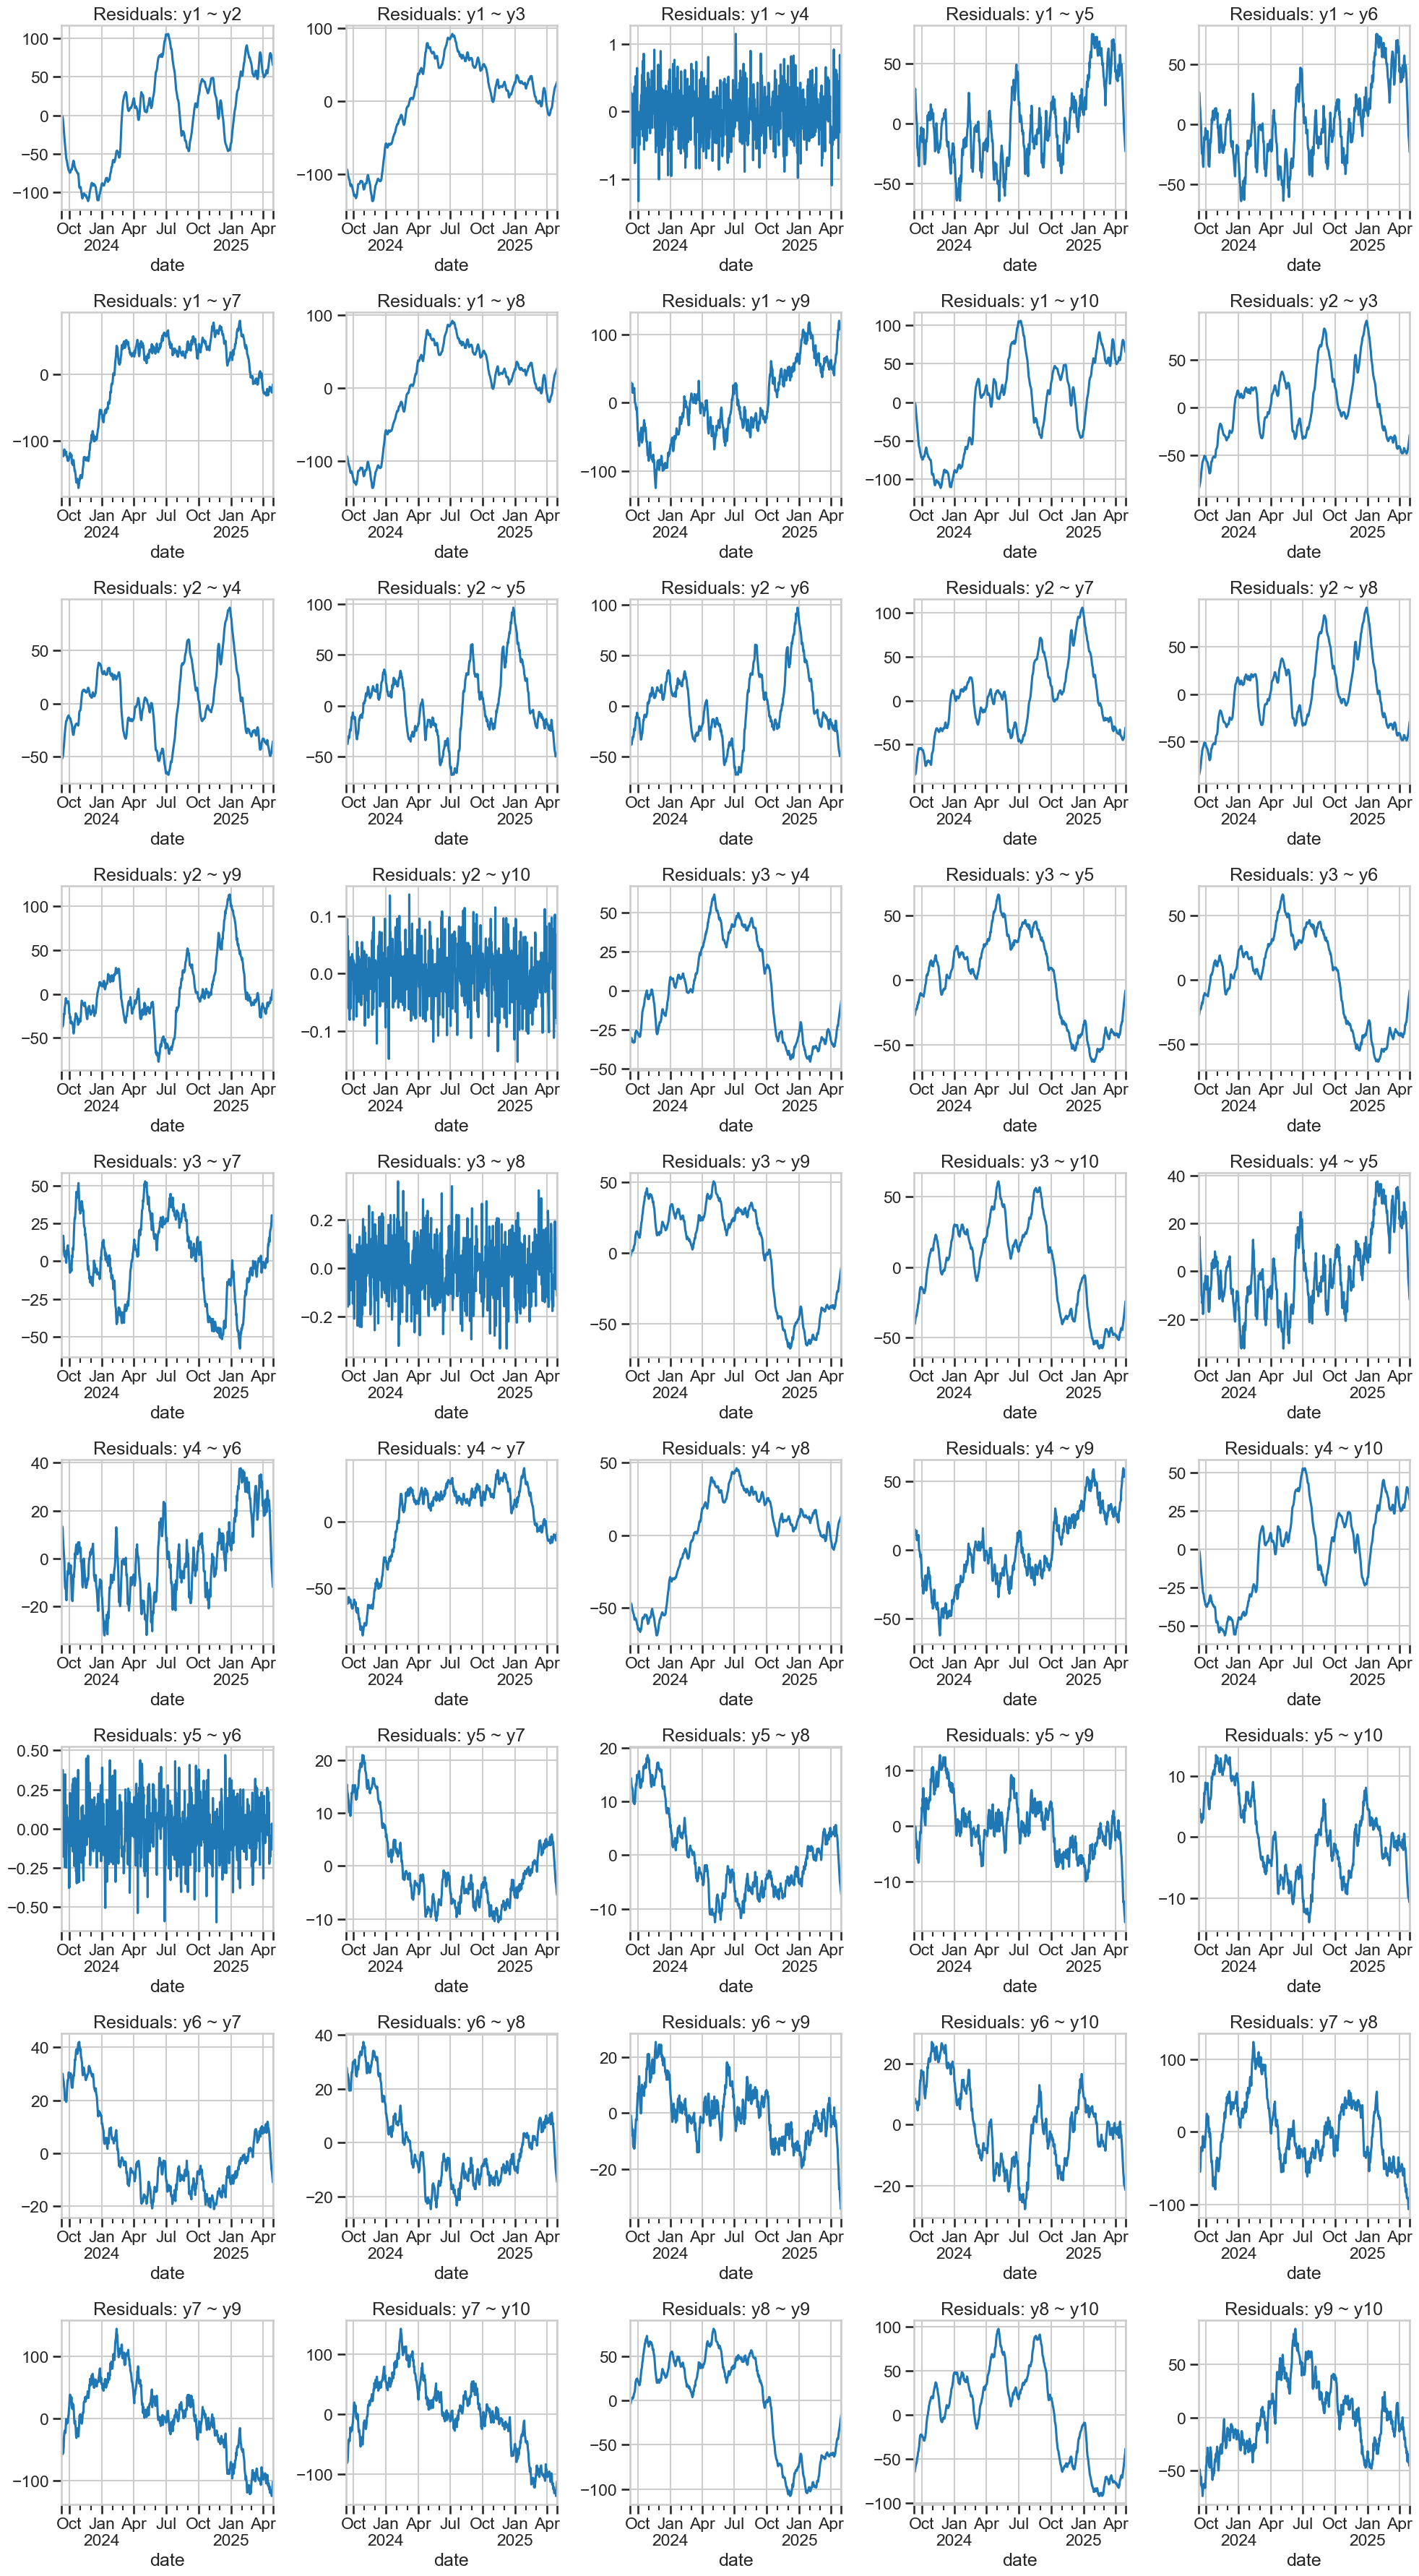

In [11]:
import matplotlib.pyplot as plt

# List of variables
Y = [f'y{i}' for i in range(1, 11)]

# Prepare figure
num_pairs = sum(1 for i in range(9) for j in range(i + 1, 10))  # 45 pairs
ncols = 5
nrows = (num_pairs + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))
axes = axes.flatten()

# Loop through pairs and plot residuals
plot_idx = 0
for i in range(9):
    for j in range(i + 1, 10):
        y_i = TS2[Y[i]]
        y_j = TS2[Y[j]]

        X_pair = sm.add_constant(y_j)
        model_pair = sm.OLS(y_i, X_pair).fit()
        resid_pair = model_pair.resid

        # Plot residuals
        ax = axes[plot_idx]
        resid_pair.plot(ax=ax)
        ax.set_title(f'Residuals: {Y[i]} ~ {Y[j]}')
        ax.grid(True)

        plot_idx += 1

# Remove any empty subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


A quick eyeballing may give potential pairs.

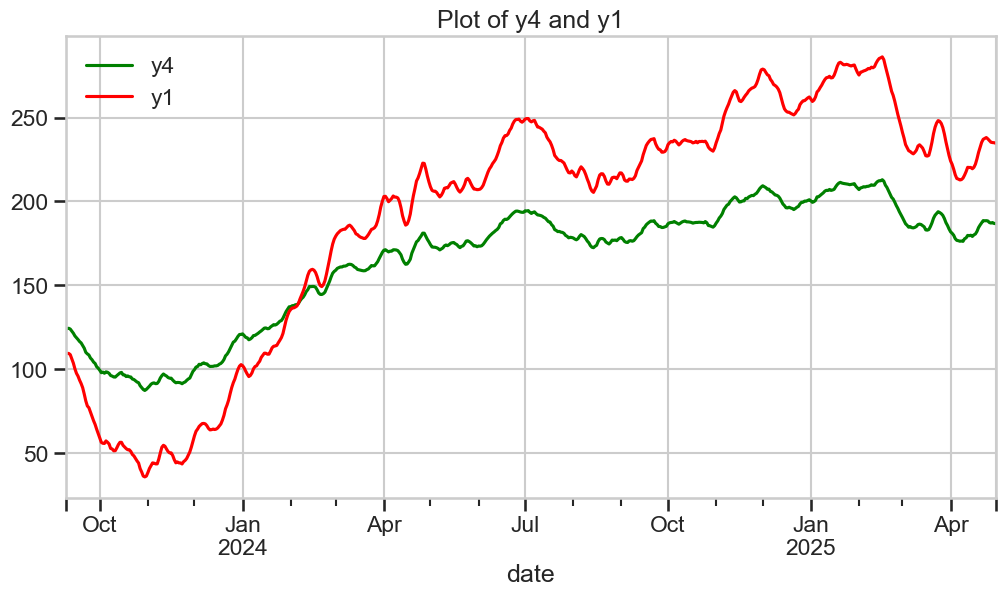

In [12]:
# Plot y4 and y8
TS2[[f'y4', f'y1']].plot(figsize=(12, 6), color=['green', 'red'], title='Plot of y4 and y1')
plt.show()


In [13]:
df = pd.read_csv("TSA_2025_project_data_1.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['x'] = df['y1']
df['y'] = df['y4']
data_pair = df[['x', 'y']]




# Johansen Cointegration Test

In [14]:

data_pair = data_pair.dropna()

johansen_result = coint_johansen(data_pair,det_order=0, k_ar_diff=6)




In [15]:
print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvm[i, 1]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 90.683
  Critical Value (95%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 1.641
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 89.042
  Critical Value (95%): 14.264
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 1.641
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.


### Johansen Test Interpretation 

* Trace test:
  r ≤ 0 → reject → there is at least 1 cointegrating vector
  r ≤ 1 → cannot reject → no more than 1 cointegrating vector

* Max eigenvalue test:
  r = 0 → reject → at least 1 cointegrating vector
  r = 1 → cannot reject → no second cointegrating vector

**Conclusion:** rank = 1 → exactly one cointegrating relationship.


# VECM

In [16]:
vecm_model = VECM(data_pair.values, k_ar_diff=6, coint_rank=1, deterministic='ci')
vecm_results = vecm_model.fit()

#vecm_results.summary() this is throwing typerrror so can not get the param significance

In [17]:


# 1. Adjustment coefficients (alpha)
print("Adjustment coefficients (alpha):")
display(pd.DataFrame(vecm_results.alpha, index=['x','y'], columns=['ECT1']))

# 2. Cointegrating vector (beta)
print("\nCointegrating vector (beta):")
display(pd.DataFrame(vecm_results.beta, index=['x','y'], columns=['beta1']))

# 3. Constant term in cointegration
print("\nConstant in cointegration relation:")
print(vecm_results.det_coef_coint)

# 4. Short-run coefficients (Gamma matrices)
print("\nShort-run dynamics coefficients (gamma):")
gammas = pd.DataFrame(vecm_results.gamma, 
                      index=['x','y'], 
                      columns=[f'L{i+1} dX' if i%2==0 else f'L{i//2+1} dY' for i in range(vecm_results.gamma.shape[1])])
display(gammas)

# 5. Residual covariance matrix (sigma_u)
print("\nResidual covariance matrix (sigma_u):")
display(pd.DataFrame(vecm_results.sigma_u, index=['x','y'], columns=['x','y']))


Adjustment coefficients (alpha):


,ECT1
x,-0.3616
y,0.3458



Cointegrating vector (beta):


,beta1
x,1.0000
y,-2.0000



Constant in cointegration relation:
[[139.42946334]]

Short-run dynamics coefficients (gamma):


,L1 dX,L1 dY,L3 dX,L2 dY,L5 dX,L3 dY,L7 dX,L4 dY,L9 dX,L5 dY,L11 dX,L6 dY
x,1.5116,-0.9452,0.2013,-0.5310,-0.2376,-0.2085,0.3394,-0.2923,0.1499,-0.2006,-0.0391,-0.0902
y,0.7421,-0.4719,0.0749,-0.1984,-0.1762,0.0138,0.1063,-0.0157,0.0236,-0.0028,-0.0336,-0.0271



Residual covariance matrix (sigma_u):


,x,y
x,0.9643,0.4792
y,0.4792,0.2748


In [18]:
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

# Get residuals
residuals = vecm_results.resid
residuals_df = pd.DataFrame(residuals, columns=['x', 'y'], index=data_pair.index[vecm_model.k_ar_diff+1:])

# === 1. Normality test (Jarque-Bera) ===
jb_x = jarque_bera(residuals_df['x'])
jb_y = jarque_bera(residuals_df['y'])

print("Jarque-Bera Test for Normality:")
print(f"X residuals: JB={jb_x[0]:.3f}, p-value={jb_x[1]:.4f}")
print(f"Y residuals: JB={jb_y[0]:.3f}, p-value={jb_y[1]:.4f}")

# === 2. Autocorrelation test (Ljung-Box) ===
lags = [12, 24, 36]

ljung_x = acorr_ljungbox(residuals_df['x'], lags=lags, return_df=True)
ljung_y = acorr_ljungbox(residuals_df['y'], lags=lags, return_df=True)

print("\nLjung-Box Test for Serial Correlation:")
print(f"\nX residuals:\n{ljung_x}")
print(f"\nY residuals:\n{ljung_y}")

Jarque-Bera Test for Normality:
X residuals: JB=1.224, p-value=0.5422
Y residuals: JB=0.777, p-value=0.6782

Ljung-Box Test for Serial Correlation:

X residuals:
    lb_stat  lb_pvalue
12  12.9522     0.3725
24  23.4916     0.4910
36  33.5277     0.5867

Y residuals:
    lb_stat  lb_pvalue
12  16.2463     0.1802
24  27.1518     0.2974
36  35.4439     0.4949


resudiala are normal.
There is no significant autocorrelation in the residuals.

# VECM Model Summary

## Model form:

$$
\Delta X_t = \alpha_1 \cdot ECT_{t-1} + \sum \gamma_{1i} \Delta X_{t-i} + \sum \gamma_{1i} \Delta Y_{t-i} + \varepsilon_{1t}
$$
$$
\Delta Y_t = \alpha_2 \cdot ECT_{t-1} + \sum \gamma_{2i} \Delta X_{t-i} + \sum \gamma_{2i} \Delta Y_{t-i} + \varepsilon_{2t}
$$

with:

$$
ECT_{t-1} = X_{t-1} - 2 \cdot Y_{t-1}
$$

(cointegration vector β = [1, -2] from the output).

---

## Cointegration Relationship:

- $ X_t $ and $ Y_t $ move in a **long-run ratio of ~2:1**.
- If $ X $ deviates from $ 2 \cdot Y $, the system tends to bring it back toward this equilibrium.

---

## Adjustment Coefficients (α):

- **X equation:** α = -0.3616  
    → X adjusts downward when $ X_{t-1} > 2 \cdot Y_{t-1} $.  
    → X helps correct disequilibrium.

- **Y equation:** α = +0.3458  
    → Y adjusts upward when $ X_{t-1} > 2 \cdot Y_{t-1} $.  
    → Y also contributes to restoring equilibrium.

**Conclusion:** Both series actively participate in error correction → this is a well-behaved system.

---

## Short-run Dynamics (Gamma):

- **X equation:**
    - Large short-run effect from $ \Delta X_{t-1} $: **1.5116**.
    - Significant short-run feedback from own lags (γ terms up to lag 7).
    - Some influence from $ \Delta Y $, but smaller.

- **Y equation:**
    - Short-run responses are smaller overall.
    - $ \Delta X $ terms (esp. first lag) contribute to Y’s short-run movements.
    - $ \Delta Y $ terms also contribute but with smaller coefficients.

**Interpretation:** X responds faster and more strongly to recent changes than Y does.

---

## Constant in Cointegration:

- Constant = **139.43** → shifts the equilibrium line vertically.

---

## Residual Covariance Matrix $ \Sigma_u $:

$$
\Sigma_u = \begin{bmatrix}
0.9643 & 0.4792 \\
0.4792 & 0.2748 \\
\end{bmatrix}
$$

- There is a moderate positive correlation between the residuals of X and Y → not surprising given the cointegration.

---

## Overall Summary:

- One stable cointegrating relationship exists between X and Y → $ X_t \approx 2 \cdot Y_t + C $.
- Both X and Y adjust to disequilibrium — X more aggressively, Y more moderately.
- Short-run dynamics are more pronounced for X → X is more volatile and reacts faster.
- The system is stable and behaves intuitively → the VECM is well specified.

# VECM to VAR

In [19]:
var_model = VAR(data_pair.values)
var_results = var_model.fit(7)  # Corresponding to k_ar_diff+1

print(var_results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Jun, 2025
Time:                     14:54:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.02441
Nobs:                     593.000    HQIC:                  -3.15985
Log likelihood:          -690.346    FPE:                  0.0389205
AIC:                     -3.24626    Det(Omega_mle):       0.0370238
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -49.896785        39.067387           -1.277           0.202
L1.y1         2.146917         0.113727           18.878           0.000
L1.y2        -0.225858         0.213169           -1.060           0.289
L2.y1        -1.302610

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for i, col in enumerate(['y1', 'y2']):
    print(f"\nLjung-Box test for {col} residuals:")
    lb_test = acorr_ljungbox(var_results.resid[:,i], lags=[12, 24, 36])
    print(lb_test)


Ljung-Box test for y1 residuals:
    lb_stat  lb_pvalue
12  12.7617     0.3866
24  23.3009     0.5021
36  33.0546     0.6094

Ljung-Box test for y2 residuals:
    lb_stat  lb_pvalue
12  16.0886     0.1872
24  26.9724     0.3057
36  35.1796     0.5074


No significant autocorrelation in the residuals

In [21]:
from statsmodels.stats.stattools import jarque_bera

for i, col in enumerate(['y1','y2']):
    jb_stat, jb_pval, _, _ = jarque_bera(var_results.resid[:,i])
    print(f"\nJarque-Bera test for {col} residuals: stat={jb_stat:.3f}, p-value={jb_pval:.3f}")


Jarque-Bera test for y1 residuals: stat=1.147, p-value=0.564

Jarque-Bera test for y2 residuals: stat=0.759, p-value=0.684


residuals are normal

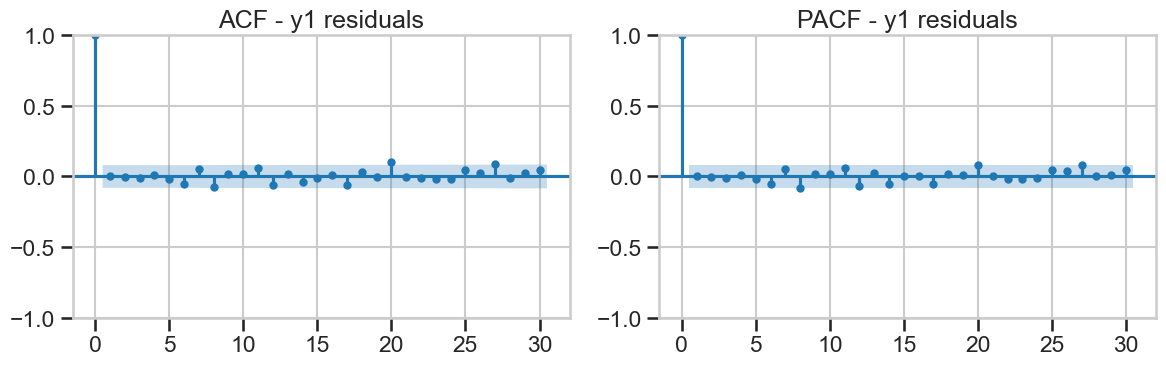

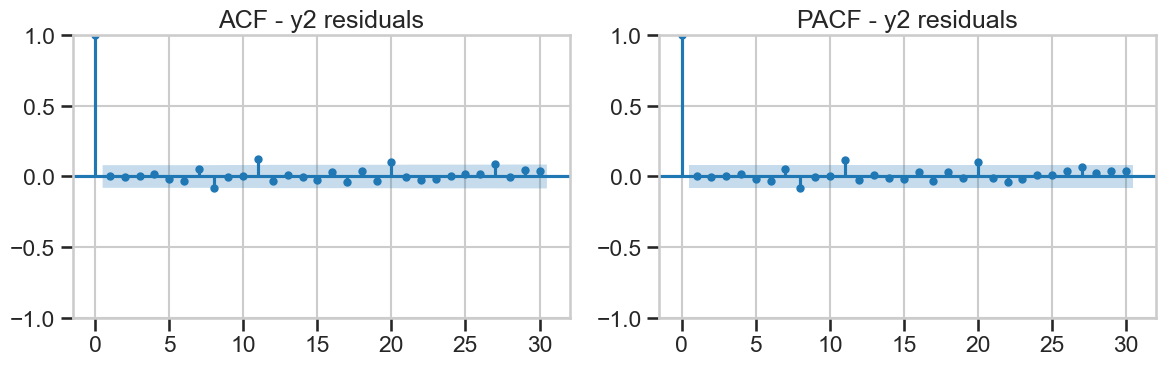

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for i, col in enumerate(['y1','y2']):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(var_results.resid[:,i], lags=30, ax=axes[0])
    axes[0].set_title(f'ACF - {col} residuals')
    plot_pacf(var_results.resid[:,i], lags=30, ax=axes[1])
    axes[1].set_title(f'PACF - {col} residuals')
    plt.tight_layout()
    plt.show()

# VAR(7) Model Summary

---

## Model Form:

$$
Y_t = c + \sum_{i=1}^{7} A_i Y_{t-i} + \varepsilon_t
$$

where:

$$ Y_t = \begin{bmatrix} y1_t \\ y2_t \end{bmatrix} $$

$$ A_i = \text{coefficient matrix for lag } i $$

$$ c = \text{constant vector} $$

$$ \varepsilon_t = \text{error terms} $$

---

## Model Fit:

- AIC = -3.246  
- BIC = -3.024  
- Log Likelihood = -690.35  
- $$ \det(\Sigma_u) = 0.037 $$

**Comment:**  
Overall fit is acceptable. Low AIC/BIC suggests good balance of model complexity vs data size ($N=593$).

---

## Dynamics in Equation for $y1$:

### Significant Lags:

- $L1.y1$, $L2.y1$, $L3.y1$, $L4.y1$ → highly significant.
- Lags of $y2$ mostly insignificant (highest $p=0.055$ on $L2.y2$).

### Equation:

$$
y1_t = c_1 + \sum_{i=1}^{7} a_i^{11} y1_{t-i} + \sum_{i=1}^{7} a_i^{12} y2_{t-i} + \varepsilon_{1t}
$$

### Interpretation:

$y1$ is primarily driven by its own past → **strong autoregressive structure**.  
Influence from $y2$ is weak.

---

## Dynamics in Equation for $y2$:

### Significant Lags:

- $L1.y1$, $L2.y1$, $L3.y1$, $L4.y1$ → highly significant → cross-variable influence.
- $L2.y2$ also significant.

### Equation:

$$
y2_t = c_2 + \sum_{i=1}^{7} a_i^{21} y1_{t-i} + \sum_{i=1}^{7} a_i^{22} y2_{t-i} + \varepsilon_{2t}
$$

### Interpretation:

$y2$ is strongly influenced by lagged $y1$.  
Own dynamics of $y2$ are weaker beyond $L2.y2$.

---

## Constant Terms:

- $c_1 = -49.90$, not significant $(p = 0.202)$.
- $c_2 = +48.49$, significant $(p = 0.020)$.

**Comment:**  
Constant in $y2$ equation suggests **mean shift or trend** in $y2$.  
No strong constant needed in $y1$.

---

## Residual Covariance Matrix $\Sigma_u$:

$$
\Sigma_u =
\begin{bmatrix}
0.9643 & 0.4792 \\
0.4792 & 0.2748 \\
\end{bmatrix}
$$

- Correlation between residuals: $\rho \approx 0.93$ → **moderately high** → expected due to cointegration / joint dynamics.

---

# Overall Interpretation:

- One variable (**$y1$**) is strongly autoregressive.
- Other variable (**$y2$**) is primarily reacting to lags of $y1$.
- System is stable, no signs of explosive behavior.

---

# Model Improvement Suggestions:

- Many higher-order lags are insignificant → model is **likely overparameterized** but reducing lag introduces autocorrelations in the residual.
- Try fitting VAR(4) — AIC/BIC may improve.
- Regularization (Ridge, Lasso) can help shrink irrelevant terms.
- Consider using VECM form instead — we know there is **cointegration**.

---

# Summary:

- VAR(7) works, but can be **simplified**.
- $y1$ → strong own memory.
- $y2$ → mostly driven by $y1$.
- Model is interpretable and fits economic intuition.

# Impulse Response Functions (IRF)

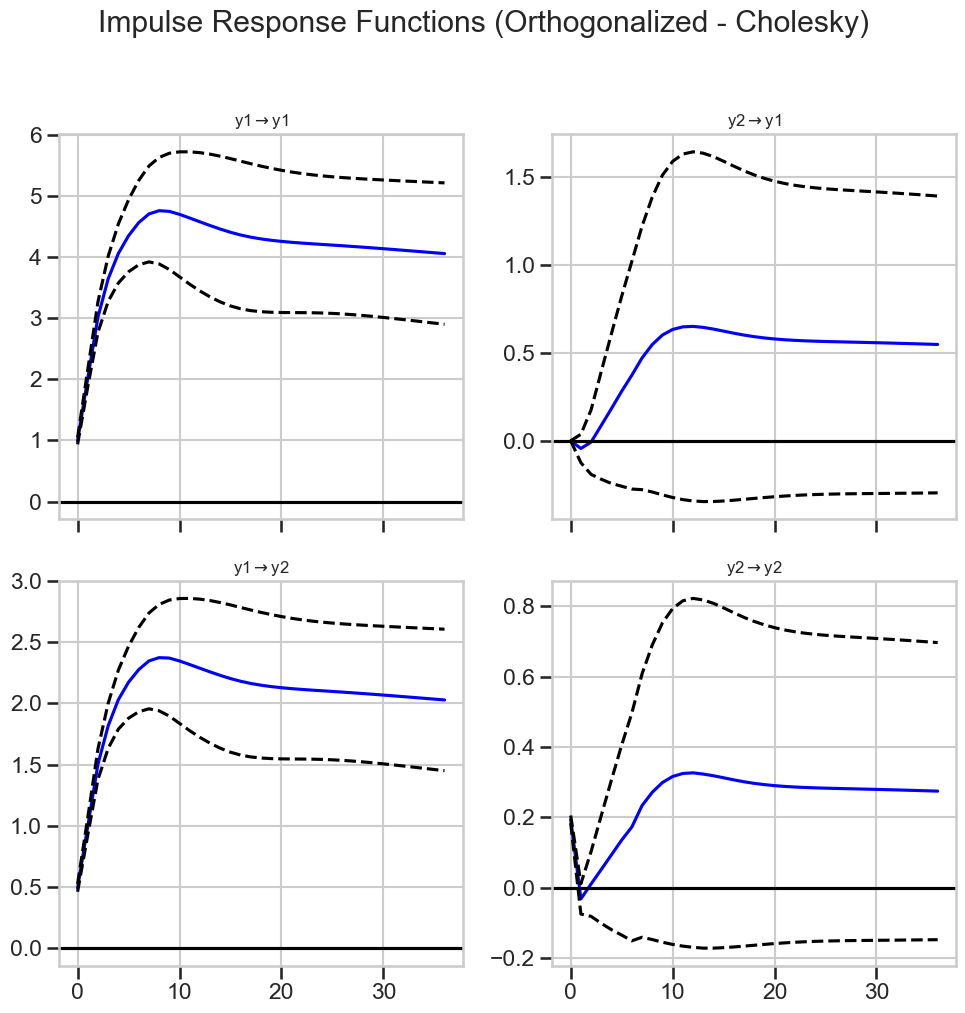

In [23]:
# Calculate and plot IRFs
irf = var_results.irf(periods=36)

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

Impulse Response Function (Orthogonalized - Cholesky) – Interpretation

**Panel y1 → y1:**

- $y_1$ responds strongly to its own orthogonal shock → peak $\sim 4.5$.
- Response decays very slowly → high persistence.
- Indicates $y_1$ has a strong internal dynamic component.

**Panel y2 → y1:**

- Orthogonal $y_2$ shock causes only a modest effect on $y_1$ → peak $\sim 0.5$.
- Effect is short-lived → stabilizes quickly.
- Suggests limited pure causal influence of $y_2$ on $y_1$.

**Panel y1 → y2:**

- $y_2$ responds significantly to orthogonal $y_1$ shock → peak $\sim 2.5$.
- Gradual decay to $\sim 2$.
- Indicates $y_1$ has a strong causal effect on $y_2$.

**Panel y2 → y2:**

- $y_2$ reacts moderately to its own orthogonal shock → peak $\sim 0.8$.
- Response decays quickly → much lower persistence than $y_1$.
- $y_2$ has more damped dynamics.

---

**Summary:**

- $y_1$ is the **dominant driver** in the system → its own shocks and influence on $y_2$ are large and persistent.
- $y_2$ has a more limited and short-lived impact, especially on $y_1$.
- System is **asymmetric** → $y_1$ leads $y_2$.
- Orthogonalization reveals the true causal structure → **most of the system’s long-term variation is driven by $y_1$**.

# Forecast Error Variance Decomposition (FEVD)

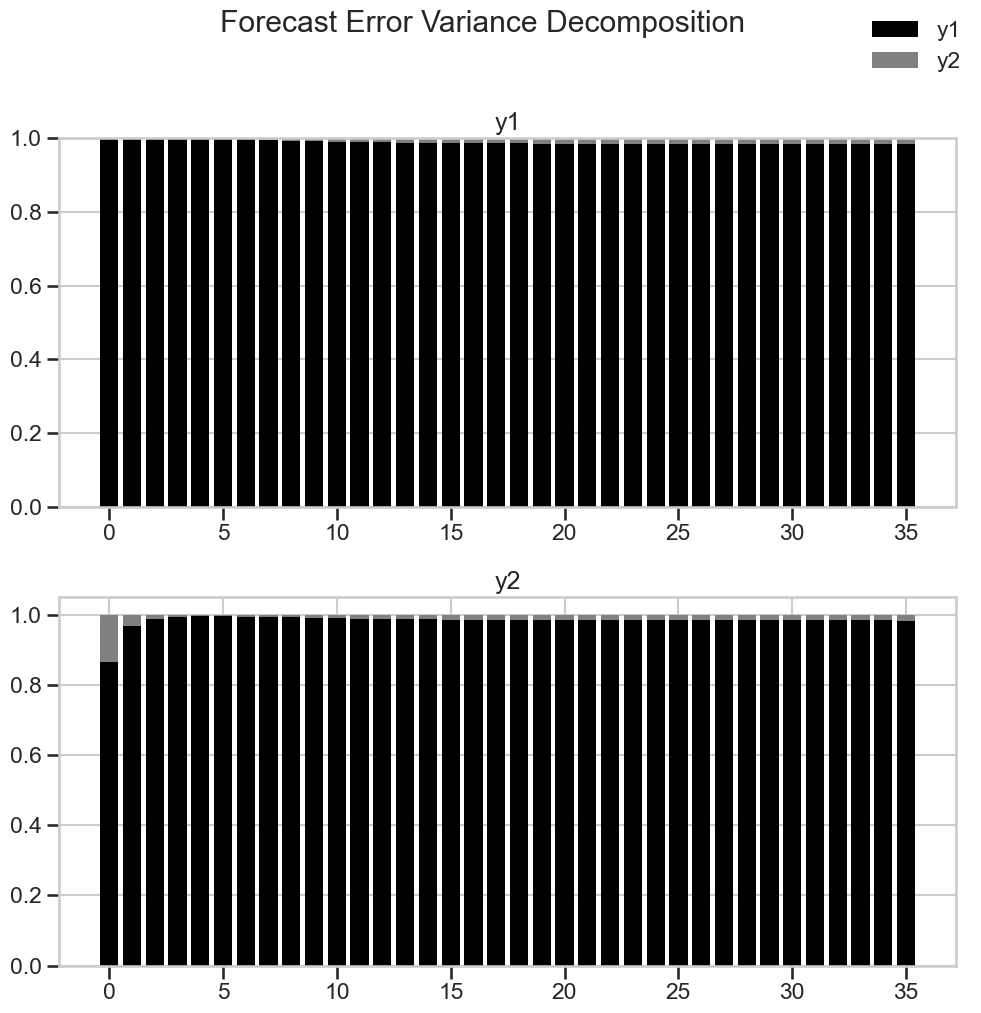

In [24]:

# Calculate and plot FEVD
fevd = var_results.fevd(periods=36)
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
#print("\nFEVD Summary (Period 36):")
#print(fevd.summary())

$ \text{Forecast Error Variance Decomposition (FEVD) – Interpretation} $

---

**y1:**

- Forecast error variance of $y_1$ is explained almost entirely (>99%) by its **own innovations** at all horizons.
- Shocks to $y_2$ contribute **negligibly** to $y_1$ variance.
- $y_1$ is **highly exogenous** → drives itself.

---

**y2:**

- At very short horizons (1-2 steps), $y_2$ variance has a small contribution (~10-15%) from $y_1$ shocks.
- However, after 3+ steps, $y_2$ variance is dominated (>95%) by **its own innovations**.
- $y_2$ is mostly driven by itself but shows **short-run sensitivity to $y_1$**.

---

**Summary:**

- The system exhibits **high degree of separability**:
    - $y_1$ is strongly self-driven and largely unaffected by $y_2$.
    - $y_2$ reacts somewhat to $y_1$ in the short run but becomes self-driven in the long run.
- Confirms the **asymmetry** seen in IRFs → $y_1$ leads system dynamics.

# Diagnostics

In [25]:
residuals = var_results.resid
# to DataFrame use value of  vecm_results.k_ar_diff + 1
residuals = pd.DataFrame(var_results.resid, columns=['x', 'y'], index=df.index[7:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_x = acorr_ljungbox(residuals['x'], lags=[10], return_df=True)
ljung_box_y = acorr_ljungbox(residuals['y'], lags=[10], return_df=True)
print("PPI Residuals:\n", ljung_box_x)
print("\nCPI Residuals:\n", ljung_box_y)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_x['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for x residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for x residuals.")
if ljung_box_y['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y residuals.")

Residuals (first 5 rows):
                 x       y
date                      
2023-09-16  0.0173  0.2391
2023-09-17  0.4502  0.2750
2023-09-18 -1.6009 -0.7892
2023-09-19 -0.1680  0.1008
2023-09-20 -0.7131 -0.5213

Ljung-Box Test for Serial Correlation in Residuals (lag=10):
PPI Residuals:
     lb_stat  lb_pvalue
10   7.9033     0.6383

CPI Residuals:
     lb_stat  lb_pvalue
10   6.6602     0.7571

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for x residuals.
 - Cannot reject H0 (no serial correlation) for y residuals.


No serial auto correlation

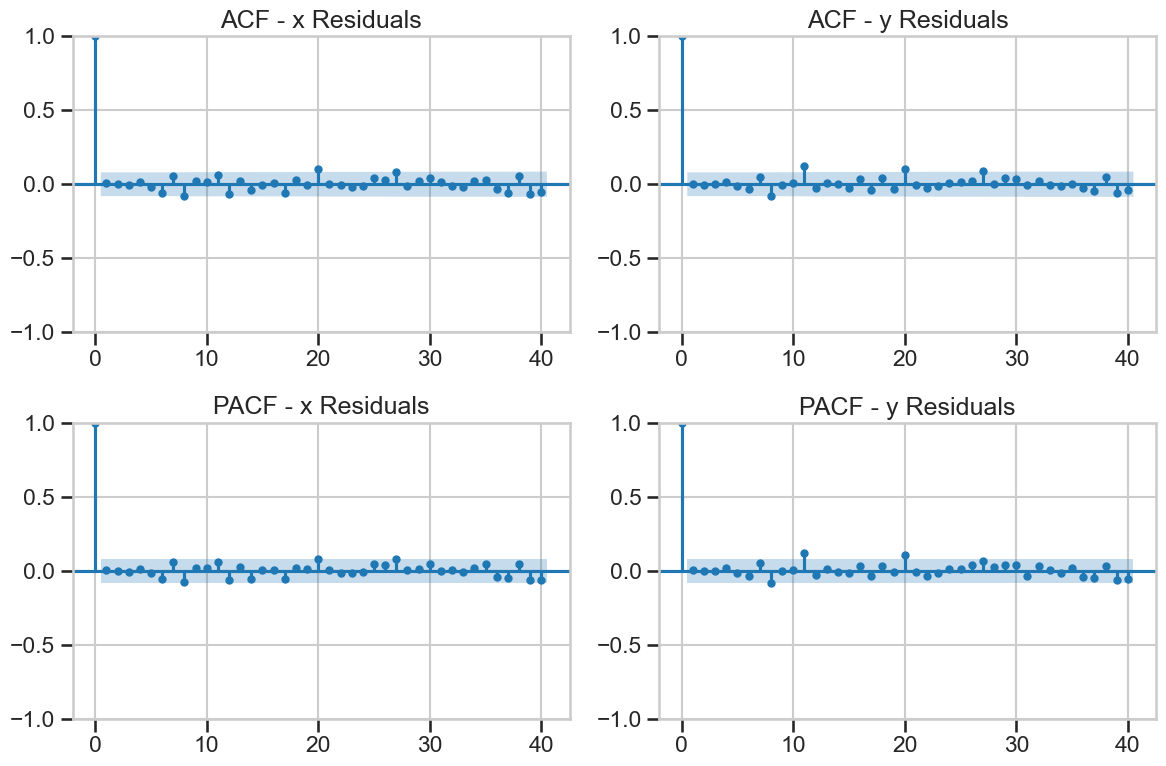

In [26]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['x'], ax=axes[0, 0], title='ACF - x Residuals', lags=40)
plot_pacf(residuals['x'], ax=axes[1, 0], title='PACF - x Residuals', lags=40, method='ywm') # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y'], ax=axes[0, 1], title='ACF - y Residuals', lags=40)
plot_pacf(residuals['y'], ax=axes[1, 1], title='PACF - y Residuals', lags=40, method='ywm')
plt.tight_layout()
plt.show()

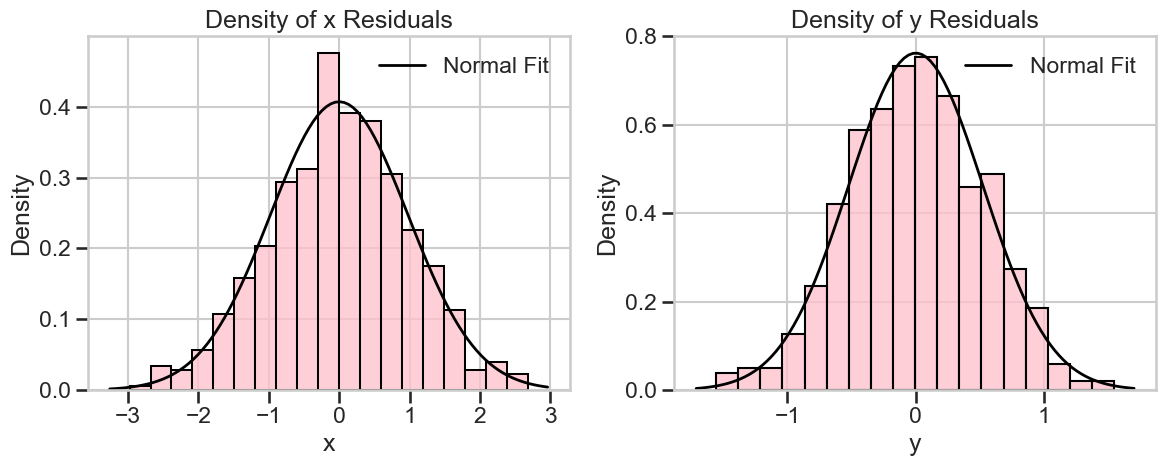

In [27]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['x'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of x Residuals')
# Overlay normal distribution
mu_x, std_x = residuals['x'].mean(), residuals['x'].std()
xmin_x, xmax_x = axes[0].get_xlim()
x_x = np.linspace(xmin_x, xmax_x, 100)
p_x = norm.pdf(x_x, mu_x, std_x)
axes[0].plot(x_x, p_x, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y Residuals')
# Overlay normal distribution
mu_y, std_y = residuals['y'].mean(), residuals['y'].std()
xmin_y, xmax_y = axes[1].get_xlim()
x_y = np.linspace(xmin_y, xmax_y, 100)
p_y = norm.pdf(x_y, mu_y, std_y)
axes[1].plot(x_y, p_y, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

In [28]:
# Test for normality (Jarque-Bera test)
jb_x_stat, jb_x_pval, _, _ = jarque_bera(residuals['x'])
jb_y_stat, jb_y_pval, _, _ = jarque_bera(residuals['y'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"X Residuals: Statistic={jb_x_stat:.3f}, p-value={jb_x_pval:.3f}")
print(f"Y Residuals: Statistic={jb_y_stat:.3f}, p-value={jb_y_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_x_pval < alpha_norm:
    print(" - Reject normality for X residuals.")
else:
    print(" - Cannot reject normality for X residuals.")
if jb_y_pval < alpha_norm:
    print(" - Reject normality for Y residuals.")
else:
    print(" - Cannot reject normality for Y residuals.")

# Multivariate Normality Test (using VECMResults method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECMResults method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")



Jarque-Bera Normality Test for Residuals:
X Residuals: Statistic=1.147, p-value=0.564
Y Residuals: Statistic=0.759, p-value=0.684

Conclusion at alpha=0.05:
 - Cannot reject normality for X residuals.
 - Cannot reject normality for Y residuals.

Multivariate Normality Test Results (using VECMResults method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 2.916, critical value: 9.488>, p-value: 0.572>


Residuals are normal.

# Forecasting

In [29]:
train = data_pair.iloc[:575]
test = data_pair.iloc[575:]



In [30]:
var_model_train = VAR(train.values)
var_results_train = var_model_train.fit(7)   # if fitting fresh

# Generate forecasts
forecast_obj = var_results_train.forecast_interval(
    train.values[-var_results_train.k_ar:], steps=25, alpha=0.05
)

# Unpack forecast
forecast_mean, lower_bound, upper_bound = forecast_obj

# Create forecast DataFrame
forecast_index = data_pair.tail(25).index
forecast_df = pd.DataFrame(forecast_mean, index=forecast_index, columns=['x_fore', 'y_fore'])

In [31]:
print(forecast_df)

             x_fore   y_fore
date                        
2025-04-06 212.6589 176.0558
2025-04-07 212.7057 176.0803
2025-04-08 213.1790 176.2815
2025-04-09 213.7874 176.5718
2025-04-10 214.4940 176.9586
2025-04-11 215.2287 177.3118
2025-04-12 215.9657 177.6990
2025-04-13 216.6009 178.0124
2025-04-14 217.1025 178.2679
2025-04-15 217.4751 178.4550
2025-04-16 217.7498 178.5899
2025-04-17 217.9618 178.6972
2025-04-18 218.1262 178.7777
2025-04-19 218.2574 178.8443
2025-04-20 218.3645 178.8979
2025-04-21 218.4588 178.9456
2025-04-22 218.5493 178.9913
2025-04-23 218.6409 179.0372
2025-04-24 218.7364 179.0853
2025-04-25 218.8364 179.1353
2025-04-26 218.9413 179.1878
2025-04-27 219.0509 179.2426
2025-04-28 219.1650 179.2996
2025-04-29 219.2825 179.3583
2025-04-30 219.4026 179.4183


In [32]:
# Create forecast interval DataFrames
forecast_lower = pd.DataFrame(lower_bound, index=forecast_index, columns=['x_lower', 'y_lower'])
forecast_upper = pd.DataFrame(upper_bound, index=forecast_index, columns=['x_upper', 'y_upper'])

# Combine forecasts and intervals
forecast_combined = pd.concat([forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined)


Forecasts and Confidence Intervals:
             x_fore   y_fore  x_lower  y_lower  x_upper  y_upper
date                                                            
2025-04-06 212.6589 176.0558 210.7048 175.0139 214.6129 177.0978
2025-04-07 212.7057 176.0803 208.2721 173.8571 217.1393 178.3035
2025-04-08 213.1790 176.2815 205.7644 172.5825 220.5937 179.9806
2025-04-09 213.7874 176.5718 203.4747 171.4234 224.1002 181.7202
2025-04-10 214.4940 176.9586 201.4488 170.4431 227.5393 183.4740
2025-04-11 215.2287 177.3118 199.6131 169.5115 230.8443 185.1121
2025-04-12 215.9657 177.6990 197.9226 168.6902 234.0088 186.7078
2025-04-13 216.6009 178.0124 196.2779 167.8650 236.9240 188.1598
2025-04-14 217.1025 178.2679 194.6758 167.0703 239.5291 189.4654
2025-04-15 217.4751 178.4550 193.1273 166.2971 241.8230 190.6130
2025-04-16 217.7498 178.5899 191.6512 165.5563 243.8484 191.6235
2025-04-17 217.9618 178.6972 190.2594 164.8611 245.6642 192.5333
2025-04-18 218.1262 178.7777 188.9445 164.2011 247.30

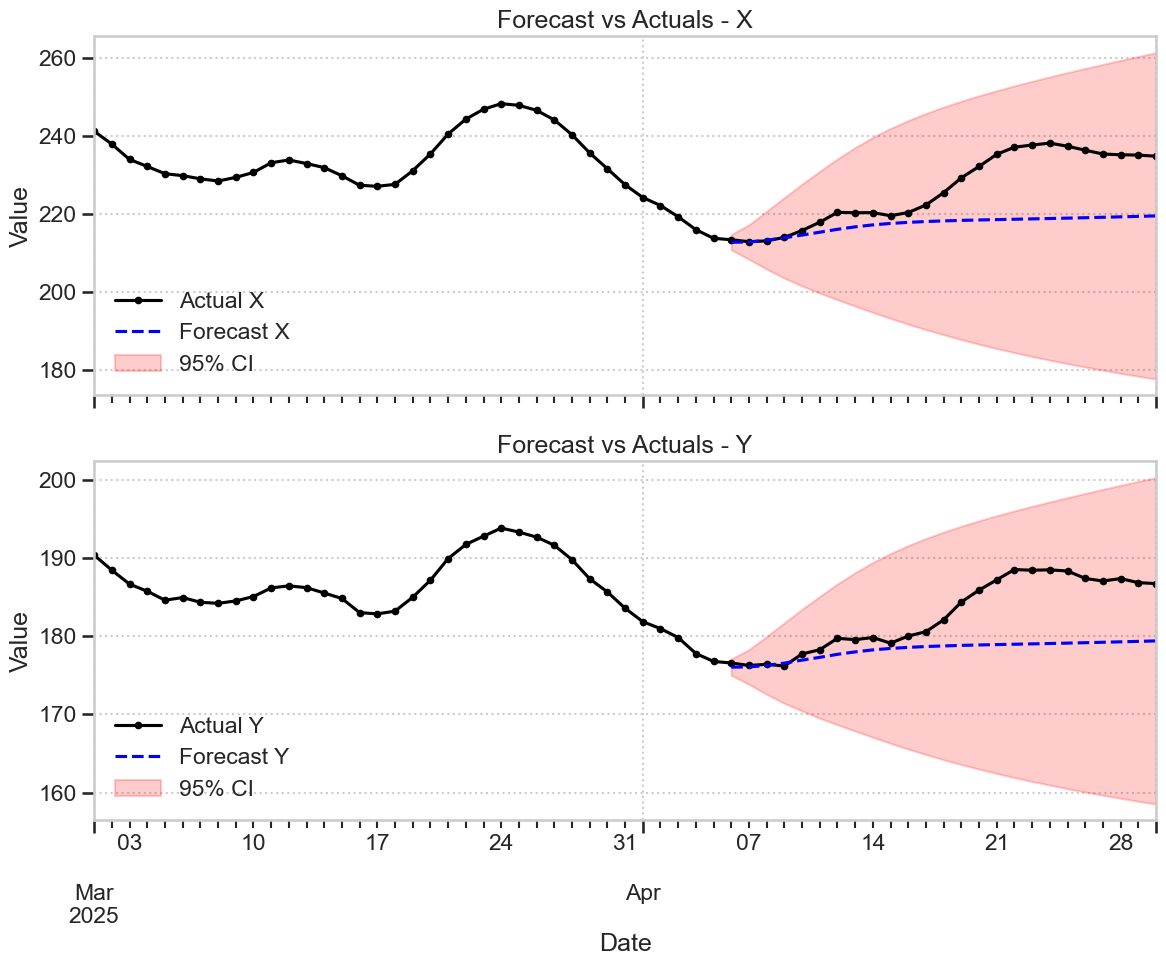

In [33]:
# Merge forecasts with the original data for plotting
df_merged = df[['x', 'y']].merge(forecast_combined, left_index=True, right_index=True, how='left')

# Plot forecasts vs actuals
plot_start_date = '2025-03-01'#'2023-09-09'  # Adjust as needed

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# X Plot
df_merged.loc[plot_start_date:, 'x'].plot(ax=axes[0], label='Actual X', color='black', marker='.')
df_merged.loc[plot_start_date:, 'x_fore'].plot(ax=axes[0], label='Forecast X', color='blue', linestyle='--')
axes[0].fill_between(df_merged.loc[plot_start_date:].index,  # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'x_lower'],
                     df_merged.loc[plot_start_date:, 'x_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('Forecast vs Actuals - X')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# Y Plot
df_merged.loc[plot_start_date:, 'y'].plot(ax=axes[1], label='Actual Y', color='black', marker='.')
df_merged.loc[plot_start_date:, 'y_fore'].plot(ax=axes[1], label='Forecast Y', color='blue', linestyle='--')
axes[1].fill_between(df_merged.loc[plot_start_date:].index,  # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'y_lower'],
                     df_merged.loc[plot_start_date:, 'y_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('Forecast vs Actuals - Y')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

#  Forecast Evaluation

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
results_df = forecast_combined
results_df['x'] = data_pair.tail(25)['x']
results_df['y'] = data_pair.tail(25)['y']
# Define MAPE and AMAPE
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def amape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / ((actual + forecast) / 2))) * 100

# Calculate metrics for x
mae_x = mean_absolute_error(results_df['x'], results_df['x_fore'])
mse_x = mean_squared_error(results_df['x'], results_df['x_fore'])
mape_x = mape(results_df['x'], results_df['x_fore'])
amape_x = amape(results_df['x'], results_df['x_fore'])

# Calculate metrics for y
mae_y = mean_absolute_error(results_df['y'], results_df['y_fore'])
mse_y = mean_squared_error(results_df['y'], results_df['y_fore'])
mape_y = mape(results_df['y'], results_df['y_fore'])
amape_y = amape(results_df['y'], results_df['y_fore'])

# Print results
print(f"\nForecast Accuracy:")
print(f"X: MAE={mae_x:.4f}, MSE={mse_x:.4f}, MAPE={mape_x:.2f}%, AMAPE={amape_x:.2f}%")
print(f"Y: MAE={mae_y:.4f}, MSE={mse_y:.4f}, MAPE={mape_y:.2f}%, AMAPE={amape_y:.2f}%")



Forecast Accuracy:
X: MAE=9.1487, MSE=137.0317, MAPE=3.92%, AMAPE=4.05%
Y: MAE=4.5264, MSE=33.5130, MAPE=2.43%, AMAPE=2.48%


**Forecast Accuracy Summary**

- **X:**
  - Mean Absolute Error (MAE): 9.15
  - Mean Squared Error (MSE): 137.03
  - Mean Absolute Percentage Error (MAPE): 3.92%
  - Adjusted MAPE (AMAPE): 4.05%

- **Y:**
  - Mean Absolute Error (MAE): 4.53
  - Mean Squared Error (MSE): 33.51
  - Mean Absolute Percentage Error (MAPE): 2.43%
  - Adjusted MAPE (AMAPE): 2.48%

**Interpretation:**
- Forecast errors are relatively low for both X and Y.
- Y shows slightly better forecast accuracy than X across all metrics (lower MAE, MSE, and MAPE).
- MAPE values under 5% suggest **good predictive performance** for both series.